In [1]:
from time import perf_counter

import numpy as np

import jax
from jax import numpy as jnp
import optax

import matplotlib.pyplot as plt

In [2]:
import continuousvmc as vmc
from continuousvmc import RotorCNN, VariationalHMC, StochasticReconfiguration, QuantumRotors
from continuousvmc.utils import tree_shape, tree_size

In [3]:
jax.default_backend()

'gpu'

## Wavefunction ansatz definition

In [4]:
logpsi = RotorCNN(dims=(4,4), kernels=[3,3], K=4, param_dtype=jnp.complex64)

In [5]:
key = jax.random.PRNGKey(42)
params = logpsi.initialize(key)

In [6]:
tree_size(params)

656

In [7]:
tree_shape(params)

FrozenDict({
    params: {
        Conv_0: {
            bias: (8,),
            kernel: (3, 3, 8, 8),
        },
        Conv_1: {
            kernel: (3, 3, 8, 1),
        },
    },
})

## The hamiltonian

We look at the Quantum Rotor Model in the continuous basis of rotor angles $\theta$

$$
H \; \mapsto \; -\frac{g J}{2} \sum _k \frac{\partial ^2}{\partial \theta _k ^2} - J \sum _{\langle k, l \rangle} \cos(\theta _k - \theta _l)
$$

on the rectangular 4x4 lattice our ansatz `logpsi` is defined on. The associated local energy function is:

$$
E_L [\psi _\alpha] (\theta) \equiv \frac{H \psi _\alpha}{\psi _\alpha} = \frac{g J}{2} \sum _k \frac{1}{\psi _\alpha} \frac{\partial ^2 \psi _\alpha }{\partial \theta _k ^2} - J \sum _{\langle k, l \rangle} \cos(\theta _k - \theta _l)
$$

We can evaluate the local energy in a numerically stable way directly from $\ln \psi _\alpha$ by employing:

$$
\frac{1}{\psi _\alpha} \frac{\partial ^2 \psi _\alpha }{\partial \theta _k ^2} = \frac{\partial ^2 \ln \psi _\alpha }{\partial \theta _k ^2} + \left( \frac{\partial \ln \psi _\alpha }{\partial \theta _k} \right) ^2
$$

and automatic differentiation (AD) from JAX. This is implemented in `QuantumRotors` class, or any local energy class inheriting from `vmc.hamiltonian.LocalEnergy`.

In [8]:
eloc = QuantumRotors(logpsi, g=6.0, pbc=False, chunk_size=4000)

We can evaluate $E_L [\psi _\alpha] (\theta) $ the way you would probably expect:

In [9]:
thetas = np.random.randn(*logpsi.dims)

In [10]:
eloc(params, thetas)

DeviceArray(4.25146+11.244156j, dtype=complex64)

as well as local energy gradients with respect to ansatz parameters $\alpha$, given samples from $| \psi _\alpha | ^2$ :

In [11]:
dummy_samples = np.random.randn(100, *logpsi.dims)

In [12]:
value, grad = eloc.value_and_grad(params, dummy_samples)

In [13]:
value # The real part

DeviceArray(-9.0529995, dtype=float32)

In [14]:
tree_shape(grad)

FrozenDict({
    params: {
        Conv_0: {
            bias: (8,),
            kernel: (3, 3, 8, 8),
        },
        Conv_1: {
            kernel: (3, 3, 8, 1),
        },
    },
})

## Sampling the wavefunction

We use the Hamiltonian Monte Carlo (HMC) algorithm for generating samples from $|\psi _\alpha | ^2$. As a quick aside: for a given generic probability distribution $P(x)$, HMC solves sthe sampling problem in a space augmented with a momentum variable $p$:

$$
P(x) \propto \int d ^N p \, \exp \left\lbrace -\frac{1}{2} p^\top M^{-1} p + \ln p(x) \right\rbrace \; .
$$

Proposals are generated by moving on surfaces of constant energy/probability through numeriacl integration of Hamilton's equations of motion. A symplectic integrator with a fixed step-size $\epsilon$ is run for $L$ steps to generate the final proposal. 

This entire setup introduces the following "hyperpameters":

* $M$ : the "momentum metric tensor" or the "mass matrix"
* $ \epsilon $ : the "step size" or "leapfrog step size"
* $ L $ : the number of proposal integrator steps

These values have to be carefully adjusted to see good chain convergence and low autocorrelation times beyond what a simple Random-Walk Metropolis (RWM) algorithm is capable of. In this code, we fix $L$ and automatically adapt $M$ and $\epsilon$ values during an extended warmup phase for each HMC chain individually.

We simply instantiate:

In [15]:
sampler = VariationalHMC(logpsi, n_samples=200, n_chains=50, warmup=600, n_leaps=40, target_acc_rate=0.8)

and sample using:

In [16]:
key, = jax.random.split(key, 1)
samples, observables, info = sampler(params, key)

In [17]:
samples.shape

(10000, 4, 4)

The resulting samples are returned as an array of shape `(n_chains * n_samples, *dims)`, collecting all samples from all independent chains along the leading axis. Furthermore, the sampler itself is highly customizable to adapt to difficult probability landscapes. Options include:

* `n_samples` : The number of samples to generate per chain.
* `n_chains` : The number of independent chains to run.
* `warmup` : The number of warmup steps to run, optionally adapting the momentum metric tensor and the leapfrog step size.
* `n_leaps` : The number of leapfrog steps to take per sample proposal.
* `adapt_step_size` : Adapt the step size during warmup/adaptation, by default True.
* `adapt_metric` : Adapt the momentum metric tensor during warmup/adaptation, by default True.
* `diagonal_metric` : Use a diagonal momentum metric tensor (as opposed to a full dense covariance matrix), by default True.
* `jitter` : Jitter to add the leapfrog trajectory length, by default 0.2. Each time a leapfrog-based proposal is generated, its trajectory length is sampled as: length ~ Uniform([(1 - `jitter`) * `n_leaps`, (1 + `jitter`) * `n_leaps`])
* `target_acc_rate` : The target acceptance rate, by default 0.65. Leapfrog step size is adjusted during warmup/adaptation to try to match this rate.
* `init_step_size_search` : Whether to perform a fast-and-cheap step size search to find the right order of magnitude before the adaptation itself, by default True.

## Optimizing the wavefunction

We use the Quantum Natural Gradient (Stochastic Reconfiguration) optimizer to find the ground state parameters. The "learning rate" can either be set to a fixed value or scheduled using schedulers from `optax`.

In [18]:
schedule = optax.polynomial_schedule(
    init_value=0.01, end_value=0.001, power=2, transition_steps=30, transition_begin=50
)

In [19]:
init, kernel = StochasticReconfiguration(
    logpsi, eloc, sampler, lr=schedule, solver='shift', eps=1e-3
)

The `kernel` represents a single optimization state and can be `jax.jit`-ed for performance. The optimizer `state` is generated by the `init` function:

In [20]:
kernel = jax.jit(kernel)
state = init(params)

Finally, we write out the optimization loop:

In [21]:
best_params = params
best_E = jnp.array(10000.0)
energies = []

In [22]:
%%time

counter = 0
clock = perf_counter()

for i in range(100):
    
    key, = jax.random.split(key, 1)
    state = kernel(state, key)
    
    energies.append(state.energy)
    counter += 1
    
    if state.energy < best_E:
        best_params = state.params
        best_E = state.energy
    
    if perf_counter() - clock > 10:
        
        acc = state.sampler_info.mean_acceptance
        dt = state.sampler_info.mean_step_size
        lr = state.learning_rate
        
        time_per_iter = (perf_counter() - clock)/counter
        
        printout = ' | '.join([
            f'Iteration {i+1:4}',
            f'Energy {state.energy: .4f}',
            f'lr {lr:.1e}',
            f'Acc. r. {acc:.2f}',
            f'Avg. dt {dt:.1e}',
            f'Time per iter. {time_per_iter:.2f} s']
        )
            
        print(printout)
        
        counter = 0
        clock = perf_counter()

Iteration    1 | Energy  7.8222 | lr 1.0e-02 | Acc. r. 0.74 | Avg. dt 7.5e-03 | Time per iter. 27.47 s
Iteration    2 | Energy  2.2091 | lr 1.0e-02 | Acc. r. 0.75 | Avg. dt 6.0e-03 | Time per iter. 26.73 s
Iteration    4 | Energy  0.2988 | lr 1.0e-02 | Acc. r. 0.76 | Avg. dt 5.5e-03 | Time per iter. 5.01 s
Iteration    6 | Energy -0.1387 | lr 1.0e-02 | Acc. r. 0.76 | Avg. dt 4.9e-03 | Time per iter. 5.01 s
Iteration    8 | Energy -0.6113 | lr 1.0e-02 | Acc. r. 0.70 | Avg. dt 6.6e-03 | Time per iter. 5.01 s
Iteration   10 | Energy -0.9201 | lr 1.0e-02 | Acc. r. 0.71 | Avg. dt 6.9e-03 | Time per iter. 5.02 s
Iteration   12 | Energy -1.1961 | lr 1.0e-02 | Acc. r. 0.70 | Avg. dt 7.5e-03 | Time per iter. 5.04 s
Iteration   14 | Energy -1.3563 | lr 1.0e-02 | Acc. r. 0.74 | Avg. dt 6.0e-03 | Time per iter. 5.06 s
Iteration   16 | Energy -1.4823 | lr 1.0e-02 | Acc. r. 0.70 | Avg. dt 7.3e-03 | Time per iter. 5.06 s
Iteration   18 | Energy -1.6041 | lr 1.0e-02 | Acc. r. 0.67 | Avg. dt 7.8e-03 | 

Plot the results:

Text(0, 0.5, 'Energy')

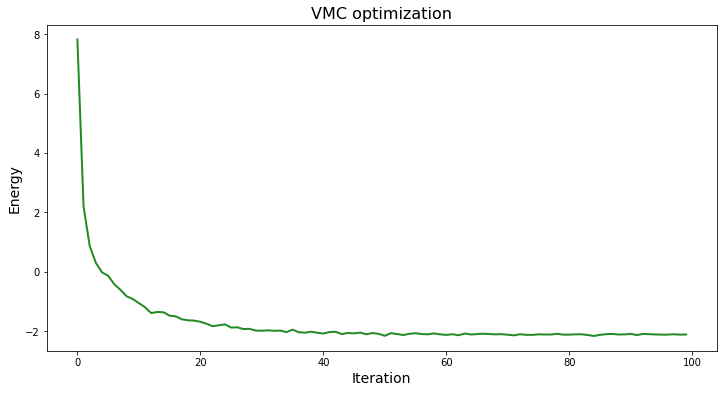

In [23]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(energies, c='forestgreen', lw=2)
ax.set_title('VMC optimization', fontsize=16)
ax.set_xlabel('Iteration', fontsize=14)
ax.set_ylabel('Energy', fontsize=14)